In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import numpy as np
import scipy
from scipy.optimize import curve_fit
import cv2
from PIL import Image
import glob

import images_library

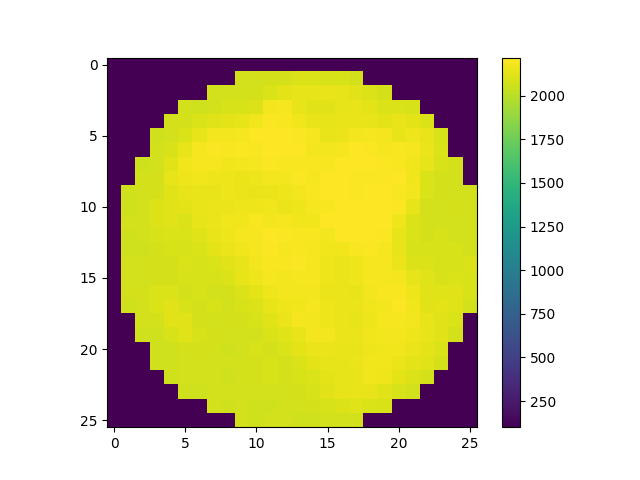

In [2]:
imArray=images_library.openImage('20221102_Flash/2022_11_03_flash_1mm/Cherenkov/Cherenkov_457_1.TIF')

x, y = np.ogrid [:len(imArray[0]) , :len(imArray[1])]
cen_x, cen_y= 275, 235 #vanno definiti in funzione della posizione della fibra scintillante
r= 13 #va impostato

imArray, ROI=images_library.findROI(imArray, x, y, cen_x, cen_y, r )
images_library.plotImage(imArray[cen_x-r:cen_x+r, cen_y-r:cen_y+r])


In [ ]:
###Buio

In [6]:
darkFiles = glob.glob(f"20221102_Flash/2022_11_03_flash_1mm/Cherenkov/*buio*.TIF")
#20221102_Flash/2022_11_03_flash_1mm/Cherenkov
#20221102_Flash/2022_11_04_flash_1mm/cerenkov
darkDict={}
images_library.fillDict(darkDict, darkFiles, "buio")


Added an image to the dictionary with key: buio_457
Added an image to the dictionary with key: buio


In [7]:
cerenkovFiles = glob.glob(f"20221102_Flash/2022_11_03_flash_1mm/Cherenkov/Cherenkov*.TIF")
#20221102_Flash/2022_11_03_flash_1mm/Cherenkov
#20221102_Flash/2022_11_04_flash_1mm/cerenkov
cerOpen={}
cerFiltered={}

images_library.fillDict(cerOpen, cerenkovFiles, "open")
images_library.fillDict(cerFiltered, cerenkovFiles, "457")

Added an image to the dictionary with key: open_1
Added an image to the dictionary with key: open_2
Added an image to the dictionary with key: open_3
Added an image to the dictionary with key: 457_2
Added an image to the dictionary with key: 457_3
Added an image to the dictionary with key: 457_1


In [11]:
cerOpenDiff = images_library.diffImDark(cerOpen, darkDict["buio"])
first = cerOpenDiff[1]

array([[-1,  2, -1, ..., -4, -6, -2],
       [-6, -3, -6, ..., -2,  5, -2],
       [ 4,  4, -7, ...,  8,  9,  1],
       ...,
       [ 7, -7, -2, ...,  2,  1,  1],
       [-4, -1,  1, ...,  0, -7, -3],
       [ 4,  6,  3, ...,  1, -3,  0]], dtype=int32)

TypeError: Invalid shape (517,) for image data

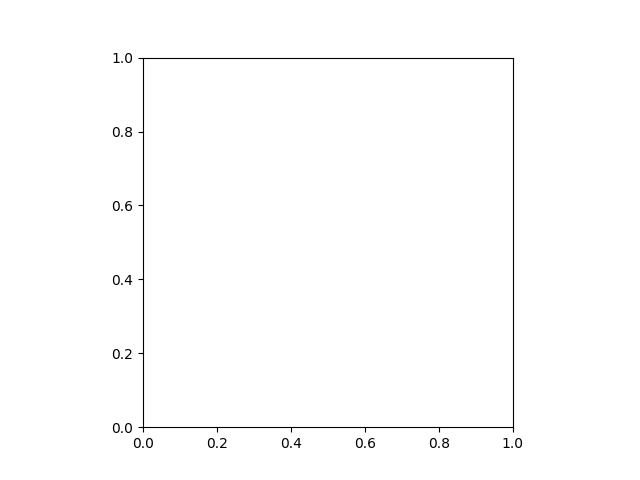

In [10]:
#OPEN
cerOpenDiff = images_library.diffImDark(cerOpen, darkDict["buio"])
lightIntegral=[]
nOfPixels=[]
for im in cerOpenDiff: 
    #im[~ROI]=0
    lightIntegral.append(np.sum(im))    
    nOfPixels.append(len(np.argwhere(im!=0)))
    images_library.plotImage(im[ROI])
    images_library.histImage(im[ROI])

    
print("N of pixels with more events than background: ", nOfPixels)
print("Light integral in the ROI: ", lightIntegral)
mean = np.array(lightIntegral)/np.array(nOfPixels)
print("Mean light in the ROI: ", mean)

cerOpenMean = np.mean(mean)
cerOpenStdev = np.std(mean)

In [ ]:
#FILTERED
cerFilteredDiff = images_library.diffImDark(cerFiltered, darkDict["buio_457"])
lightIntegral=[]
nOfPixels=[]
for im in cerFilteredDiff: 
    #im[~ROI]=0
    lightIntegral.append(np.sum(im))    
    nOfPixels.append(len(np.argwhere(im!=0)))
    images_library.plotImage(im)
    
print("N of pixels with more events than background: ", nOfPixels)
print("Light integral in the ROI: ", lightIntegral)
mean = np.array(lightIntegral)/np.array(nOfPixels)
print("Mean light in the ROI: ", mean)

cerFilteredMean = np.mean(mean)
cerFilteredStdev = np.std(mean)

In [ ]:
print('OPEN case:\n Mean: %d, Stdev: %d' % (cerOpenMean, cerOpenStdev))
print('FILTERED case:\n Mean: %d, Stdev: %d' % (cerFilteredMean, cerFilteredStdev))
